In [1]:
# Parameter inference of Eclipse 1919 data, with a strong prior on alpha.  Set Gravity flag to 'E' or 'N' for
# Einstein or Newton gravity.  Produces ascii file that can be used in MCEvidence for Bayesian Evidence calculation.

import sys
import numpy as np 
import matplotlib.pylab as plt 
#import scipy.stats as ss 
#from datetime import datetime
#from scipy.stats import multivariate_normal
#from numpy.linalg import inv
import pickle 
#from functools import reduce
#from scipy import random, linalg
import math
import pystan as ps
import csv
import arviz as az
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})
figSize  = (10, 6)
figSize1 = (8, 8)
fontSize = 22

fileDirectory = './'

In [3]:
# Stan HMC sampler

eclipse_model = """
data {
    int<lower=7> n;
    int<lower=4> m;
    vector[n]    x;
    vector[n]    y;
    vector[n]    dx;
    vector[n]    errx;
    vector[n]    Einsteinx;
    vector[n]    ones;
//    vector[n]    dy;
//    vector[n]    erry;
//    vector[n]    Einsteinxy;
    real         scale;
    real         alpha_fixed;
}
parameters {
    real   a;
    real   b;
    real   c;
    real   alpha;
}
model {

// Put Newtonian or Einstein prior on alpha:

    alpha ~ normal(alpha_fixed,0.001);
    
    dx ~ normal(a*x + b*y + c*ones + alpha*scale*Einsteinx, errx);
}
"""


In [4]:
recompile = False

if recompile:
    eclipse_model = ps.StanModel(model_code = eclipse_model)
    with open('HMC_stan_1919_MCE.pkl', 'wb') as f:
        pickle.dump(eclipse_model, f)
else:
    with open('HMC_stan_1919_MCE.pkl', 'rb') as f:
        eclipse_model = pickle.load(f)

In [5]:
# Set up data, and parameters

#-----------------------
n       = 7
m       = 4
sigma   = 0.05

# Final number of samples from 2 chains is double this:

samples = 5000
#-----------------------
warmup       = int(samples * 0.1)

samples      = samples + warmup

stanchains   = 2
totalsamples = stanchains*(samples-warmup)
#------------------------

# If gravity model is fixed, set this to 1.75 (Einstein) or 0.875 (Newton):

Gravity = 'E'

if(Gravity=='N'):
    alpha_fixed = 0.875
else:
    alpha_fixed = 1.75
    
x         = np.zeros(n)
dx        = np.zeros(n)
dx_142a   = np.zeros(n)
y         = np.zeros(n)
dy        = np.zeros(n)
Einsteinx = np.zeros(n)
ones      = np.ones(n)
errx      = np.ones(n) * sigma

micrometer  = 6.25
scaletolimb = 50.0/15.8
scale       = 1./(micrometer * scaletolimb)

x         = [-1.261,-0.160,0.334,0.348,0.587,0.860,1.079]
y         = [-0.160,-1.107,0.472,0.360,1.099,1.321,-0.328]
Einsteinx = [-0.587,-0.557,-0.186,-0.222,0.080,0.158,1.540]

# Plate I.  Subtract -1.500
#dx = [0.589,0.452,0.284,0.263,0.158,0.211,0.711]
# Plate II.  Subtract -1.500

dxraw = [-1.416,-1.221,-1.054,-1.079,-1.012,-0.999,-0.733]
dx = dxraw + 1.500*ones

#dx = [0.084,0.279,0.446,0.421,0.488,0.501,0.767]

# Subtract comparison plate 14_2a offsets:

dx_142a = [-0.478,-0.544,-0.368,-0.350,-0.317,-0.272,-0.396]
dx_142a = dx_142a + 0.552*ones

dx = dx - dx_142a


In [6]:
# Run Stan:

eclipse_data    = {'alpha_fixed': alpha_fixed,'m': m,'n': n,'x': x,'y': y,'dx': dx,'Einsteinx': Einsteinx,'errx': errx,'ones': ones,'scale': scale}
eclipse_fit     = eclipse_model.sampling(data = eclipse_data, iter = samples, warmup = warmup, chains = stanchains, algorithm='HMC')
eclipse_samples = eclipse_fit.extract(pars = ('a','b','c','alpha', 'lp__'), permuted = True)
print (eclipse_fit)

Inference for Stan model: anon_model_51578a94f2006a52c1b40bb298250dc5.
2 chains, each with iter=5500; warmup=500; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a       0.16  6.3e-4   0.03   0.11   0.14   0.16   0.18   0.22   2095    1.0
b      -0.11  6.1e-4   0.03  -0.16  -0.13  -0.11  -0.09  -0.06   1844    1.0
c       0.24  4.5e-4   0.02    0.2   0.23   0.24   0.26   0.28   2091    1.0
alpha   1.75  1.2e-5 8.4e-4   1.75   1.75   1.75   1.75   1.75   4840    1.0
lp__   -2.59    0.04   1.31  -5.94  -3.23  -2.29  -1.64  -1.01    945   1.01

Samples were drawn using HMC at Fri Jul 26 10:16:23 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


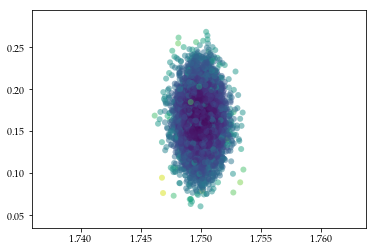

In [7]:
lnL     =  eclipse_samples['lp__']
colours = -eclipse_samples['lp__']
plt.scatter(eclipse_samples['alpha'], eclipse_samples['a'], c = colours, \
           edgecolor = 'none', alpha = 0.5)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


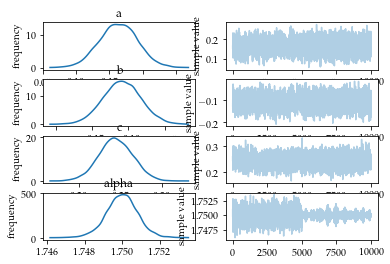

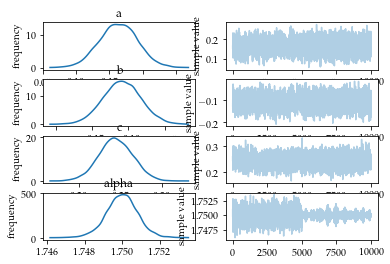

In [8]:
eclipse_fit.plot()

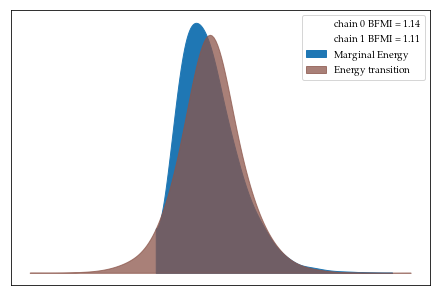

In [9]:
inf_data = az.convert_to_inference_data(eclipse_fit)
az.plot_energy(inf_data)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2933b898>,
      dtype=object)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


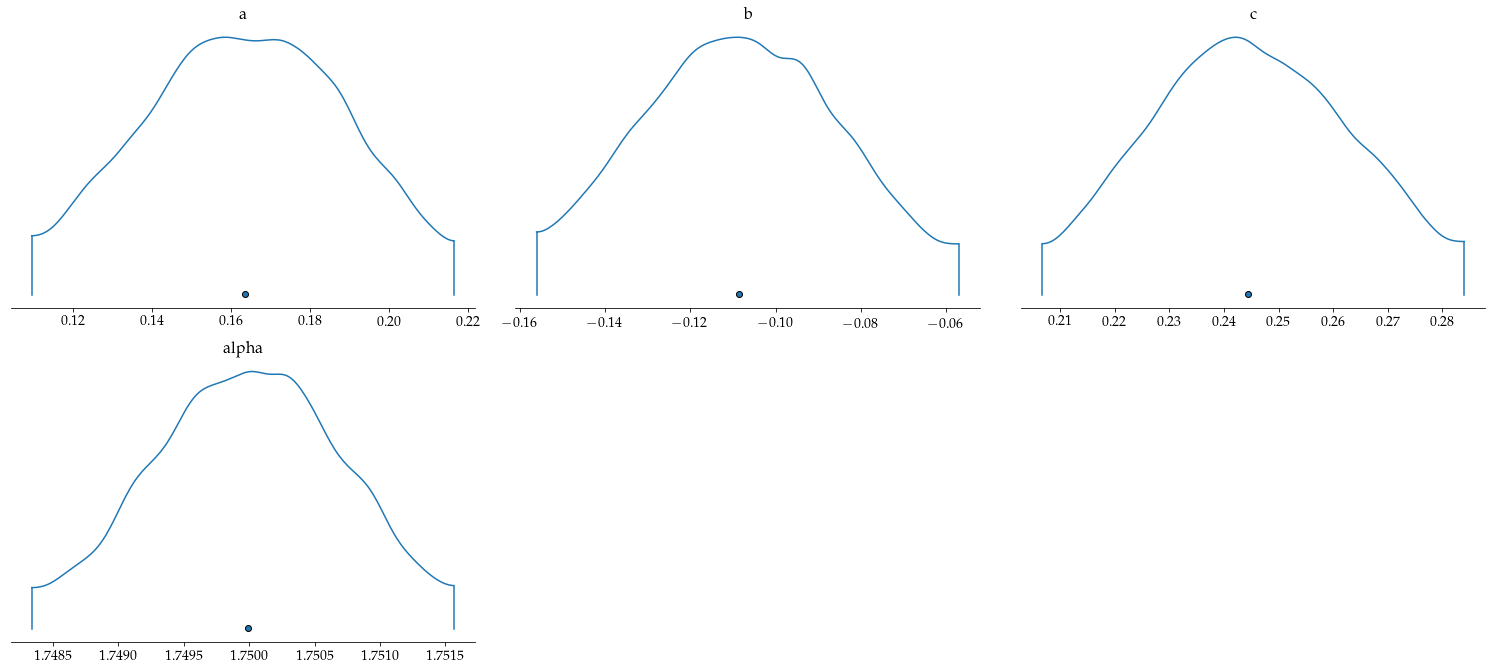

In [10]:
az.plot_density(inf_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c291bd6d8>,
      dtype=object)

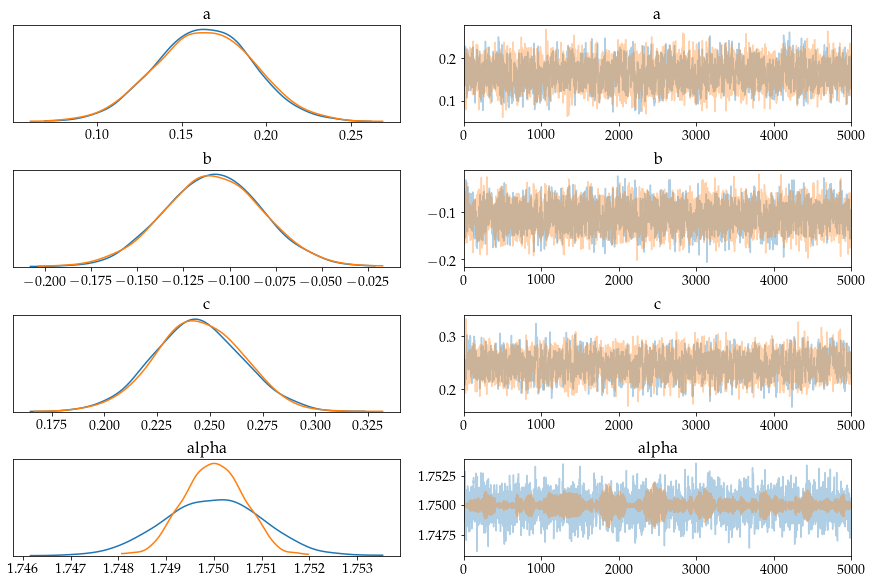

In [11]:
az.plot_trace(eclipse_fit)

(10000, 4)


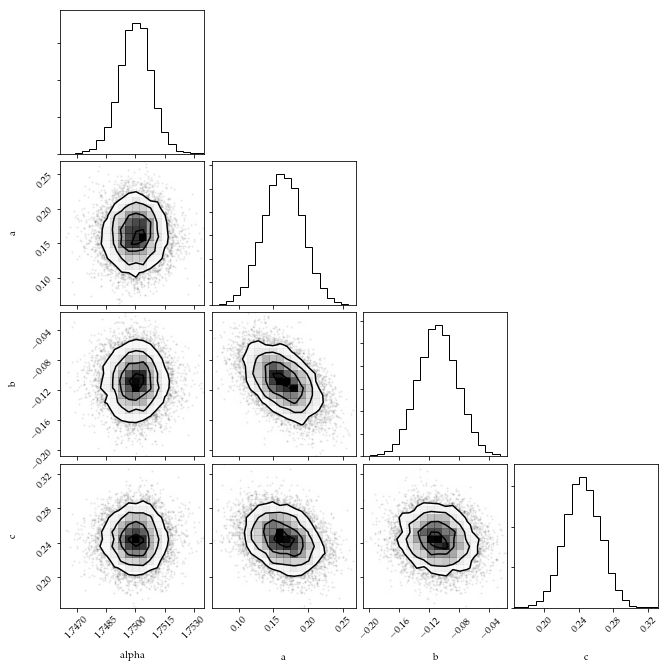

In [12]:
samples = np.array([eclipse_samples['alpha'],eclipse_samples['a'], eclipse_samples['b'], eclipse_samples['c']]).T
print (samples.shape)
import corner
tmp = corner.corner(samples[:,:], labels=['alpha','a','b','c']) 

In [13]:
chainlen = samples.shape[0]
weights  = np.ones(chainlen)

# Note that MCEvidence requires -lnL:

chain = np.array([weights, -eclipse_samples['lp__'],eclipse_samples['alpha'],eclipse_samples['a'], eclipse_samples['b'], eclipse_samples['c']]).T
with open("Eclipse_chain_"+str(chainlen)+Gravity+'_', "w") as f:
   writer = csv.writer(f, delimiter=" ")
   writer.writerows(chain)